# Trabalho de Conclusão de Curso - Projeto Final

# BI MASTER - BUSINESS INTELLIGENCE MASTER - 
# SISTEMAS INTELIGENTES DE APOIO À DECISÃO EM NEGÓCIOS 

## Aluno: Fábio Mendonça dos Santos

## Matricula: 201.190.260 

## Orientador : Professor Leonardo Alfredo Forero Mendonza

Este nottebook realiza a análise de sentimentos utilizando redes neurais CNN

e LSTM com utilização de embeddings

Foi utilizado neste scripit o label Emotion_class, gerado no scripit 

tcc_fabio_tweets_classificação_sentimentos_emoções.ipynb.

Foi feito um pré-processamento no qual foram aplicados os tratamentos de 

expandir as contarções e a demojização

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# string processing packages
!pip install emoji
import emoji
import string
import re

# nlp packages
!pip install nltk
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 170 kB 4.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169313 sha256=9b678ff3e07f47c72e21f87285820bb44ed87f4eea6d6783e76b037817f689ba
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


# Carga dos Dados

In [ ]:
# Mapeia o drive para ao final salvar o arquivo com os tweets
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:

path = '/content/drive/MyDrive/tweets/'
df = pd.read_csv(path+'tweets_csv_classified.csv', engine='python',sep=';',usecols=['tweet','Emotion_class'])
pd.set_option('display.max_colwidth', -1)

df.head()

,tweet,Emotion_class
0,Of course there would be a Cracker Barrel in Santa Maria,Fear
1,This book should be an interesting read. https://t.co/QQc4bTpvWc,Happy
2,Plan 9 Crunch: All About Cult Films: Criswell: The narrator from the coffin: https://t.co/484XebDE1V,Sad
3,@jonbonjovi @BonJovi \nRemember 10 years ago when Jon had to prove he’s still with us? Merry Christmas Jon! 🎄🎅🏼🎁 https://t.co/5IzFCVkRSu,Happy
4,It’s soooooo yachty… https://t.co/S4bBEiPvnR,Happy


In [ ]:
df.tail()

,tweet,Emotion_class
210298,Of course I get a flat 🥲,Sad
210299,Went to bed 3 hrs ago. Still not asleep. 🤦‍♀️,Angry
210300,@YaOnlyLivvOnce Nice,Happy
210301,@ivoted4djt @fox13seattle Nobody cares about South Africa.\n\nThat may have something to do with it.,Sad
210302,@reallysadcow That’s fair. I’ve never lived close enough to a 5 guys to go often but it always hits different,Happy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210303 entries, 0 to 210302
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   tweet          210303 non-null  object
 1   Emotion_class  210303 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [ ]:
df.shape

(210303, 2)

# Análise Estatística

#### Distribuição de tweets por Classe


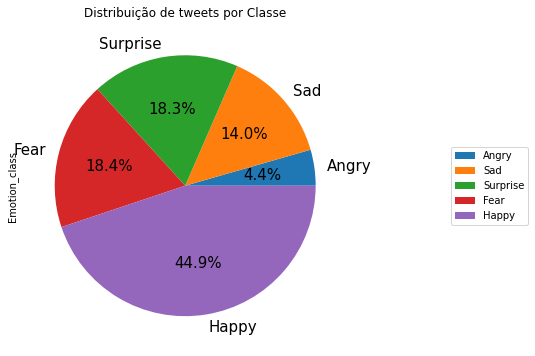

In [ ]:
df_distribution = df.Emotion_class.value_counts()\
                            .to_frame()\
                            .sort_values('Emotion_class')

df_distribution.plot.pie(y='Emotion_class', autopct='%1.1f%%',\
                            title='Distribuição de tweets por Classe',\
                            figsize=(6, 6), textprops = {"fontsize": 15}, labeldistance = 1.1)\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='medium')

plt.show;   

# Tamanho do Texto

In [ ]:

df['text_length'] = df['tweet'].apply(len)
df[['Emotion_class','text_length','tweet']].head()

,Emotion_class,text_length,tweet
0,Fear,56,Of course there would be a Cracker Barrel in Santa Maria
1,Happy,64,This book should be an interesting read. https://t.co/QQc4bTpvWc
2,Sad,100,Plan 9 Crunch: All About Cult Films: Criswell: The narrator from the coffin: https://t.co/484XebDE1V
3,Happy,139,@jonbonjovi @BonJovi \nRemember 10 years ago when Jon had to prove he’s still with us? Merry Christmas Jon! 🎄🎅🏼🎁 https://t.co/5IzFCVkRSu
4,Happy,44,It’s soooooo yachty… https://t.co/S4bBEiPvnR


In [ ]:
df['text_length'].describe()

count    210303.000000
mean     84.490939    
std      41.578471    
min      4.000000     
25%      48.000000    
50%      78.000000    
75%      132.000000   
max      220.000000   
Name: text_length, dtype: float64

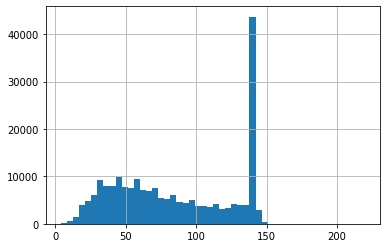

In [ ]:
df['text_length'].hist(bins=50);

# Tamanho dos tweets por classe

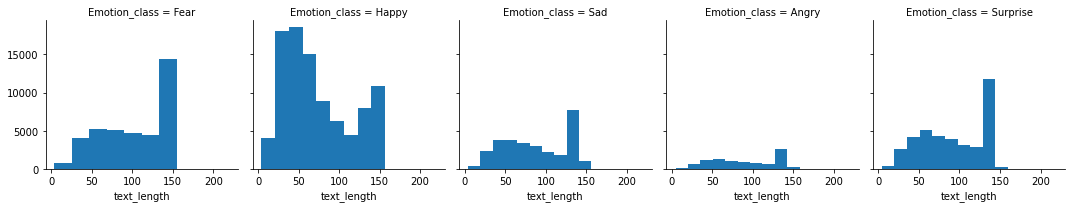

In [ ]:
g = sns.FacetGrid(df,col='Emotion_class')
g.map(plt.hist,'text_length');

## Pré-processamento da base

In [ ]:
# Converte os emoticons nos seus significados em palavras
def load_dict_emoticons():
    '''
    Load a dictionary of emoticons as keys and their word equivalents
    as values.


    Source
    ------
    https://towardsdatascience.com/twitter-sentiment-analysis-using-fasttext-9ccd04465597
    '''

    return {
        ":‑)": "smiley",
        ":-]": "smiley",
        ":-3": "smiley",
        ":->": "smiley",
        "8-)": "smiley",
        ":-}": "smiley",
        ":)": "smiley",
        ":]": "smiley",
        ":3": "smiley",
        ":>": "smiley",
        "8)": "smiley",
        ":}": "smiley",
        ":o)": "smiley",
        ":c)": "smiley",
        ":^)": "smiley",
        "=]": "smiley",
        "=)": "smiley",
        ":-))": "smiley",
        ":‑D": "smiley",
        "8‑D": "smiley",
        "x‑D": "smiley",
        "X‑D": "smiley",
        ":D": "smiley",
        "8D": "smiley",
        "xD": "smiley",
        "XD": "smiley",
        ":‑(": "sad",
        ":‑c": "sad",
        ":‑<": "sad",
        ":‑[": "sad",
        ":(": "sad",
        ":c": "sad",
        ":<": "sad",
        ":[": "sad",
        ":-||": "sad",
        ">:[": "sad",
        ":{": "sad",
        ":@": "sad",
        ">:(": "sad",
        ":'‑(": "sad",
        ":'(": "sad",
        ":‑P": "playful",
        "X‑P": "playful",
        "x‑p": "playful",
        ":‑p": "playful",
        ":‑Þ": "playful",
        ":‑þ": "playful",
        ":‑b": "playful",
        ":P": "playful",
        "XP": "playful",
        "xp": "playful",
        ":p": "playful",
        ":Þ": "playful",
        ":þ": "playful",
        ":b": "playful",
        "<3": "love"
    }


# Expande as contrações e expressões
def load_dict_contractions():
    '''
    https://www.dummies.com/social-media/twitter/use-twitter-shorthand/
    Load a dictionary of contractions as keys and their expanded words
    as values.


    Source (modified)
    ------
    https://towardsdatascience.com/twitter-sentiment-analysis-using-fasttext-9ccd04465597
    '''

    return {
        "ain't": "is not",
        "amn't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "cuz": "because",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "could've": "could have",
        "daren't": "dare not",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "d'you": "do you",
        "e'er": "ever",
        "em": "them",
        "'em": "them",
        "everyone's": "everyone is",
        "finna": "fixing to",
        "gimme": "give me",
        "gonna": "going to",
        "gon't": "go not",
        "gotta": "got to",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how would",
        "how'll": "how will",
        "how're": "how are",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i'm'a": "i am about to",
        "i'm'o": "i am going to",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "it’s": "it is",
        "i've": "i have",
        "kinda": "kind of",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "may've": "may have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "might've": "might have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "must've": "must have",
        "needn't": "need not",
        "needn't've": "need not have",
        "ne'er": "never",
        "o'": "of",
        "o'clock": "of the clock",
        "o'er": "over",
        "ol'": "old",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shalln't": "shall not",
        "shan't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "should've": "should have",
        "so's": "so as",
        "so've": "so have",
        "somebody's": "somebody is",
        "someone's": "someone is",
        "something's": "something is",
        "that'd": "that would",
        "that'd've": "that would have",
        "that'll": "that will",
        "that're": "that are",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there'll": "there will",
        "there're": "there are",
        "there's": "there is",
        "these're": "these are",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "this's": "this is",
        "those're": "those are",
        "to've": "to have",
        "'tis": "it is",
        "tis": "it is",
        "'twas": "it was",
        "twas": "it was",
        "wanna": "want to",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "weren't": "were not",
        "we've": "we have",
        "what'd": "what did",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where're": "where are",
        "where's": "where is",
        "where've": "where have",
        "which's": "which is",
        "will've": "will have",
        "who'd": "who would",
        "who'd've": "who would have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who're": "who are",
        "who's": "who is",
        "who've": "who have",
        "why'd": "why did",
        "why're": "why are",
        "why've": "why have",
        "why's": "why is",
        "won't": "will not",
        "won't've": "will not have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "would've": "would have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have",
        "Whatcha": "What are you",
        "luv": "love",
        "sux": "sucks",
        "abt": "about",
        "aint": "is not",
        "amnt": "am not",
        "arent": "are not",
        "cant": "cannot",
        "cantve": "cannot have",
        "cuz": "because",
        "couldnt": "could not",
        "couldntve": "could not have",
        "couldve": "could have",
        "darent": "dare not",
        "didnt": "did not",
        "doesnt": "does not",
        "dont": "do not",
        "dyou": "do you",
        "eer": "ever",
        "everyones": "everyone is",
        "gon": "going to",
        "hadnt": "had not",
        "hadntve": "had not have",
        "hasnt": "has not",
        "havent": "have not",
        "hed": "he would",
        "hedve": "he would have",
        "hellve": "he will have",
        "hes": "he is",
        "howd": "how would",
        "howll": "how will",
        "howre": "how are",
        "hows": "how is",
        "id": "i would",
        "idve": "i would have",
        "illve": "i will have",
        "im": "i am",
        "ima": "i am about to",
        "isnt": "is not",
        "itd": "it would",
        "itdve": "it would have",
        "itll": "it will",
        "itllve": "it will have",
        "ive": "i have",
        "lets": "let us",
        "maam": "madam",
        "maynt": "may not",
        "mayve": "may have",
        "mightnt": "might not",
        "mightntve": "might not have",
        "mightve": "might have",
        "mustnt": "must not",
        "mustntve": "must not have",
        "mustve": "must have",
        "neednt": "need not",
        "needntve": "need not have",
        "neer": "never",
        "oclock": "of the clock",
        "oer": "over",
        "ol": "old",
        "oughtnt": "ought not",
        "oughtntve": "ought not have",
        "shallnt": "shall not",
        "shant": "shall not",
        "shantve": "shall not have",
        "shedve": "she would have",
        "shellve": "she will have",
        "shes": "she is",
        "shouldnt": "should not",
        "shouldntve": "should not have",
        "shouldve": "should have",
        "sove": "so have",
        "somebodys": "somebody is",
        "someones": "someone is",
        "somethings": "something is",
        "thatd": "that would",
        "thatdve": "that would have",
        "thatll": "that will",
        "thatre": "that are",
        "thats": "that is",
        "thered": "there would",
        "theredve": "there would have",
        "therell": "there will",
        "therere": "there are",
        "theres": "there is",
        "thesere": "these are",
        "theyd": "they would",
        "theydve": "they would have",
        "theyll": "they will",
        "theyllve": "they will have",
        "theyre": "they are",
        "theyve": "they have",
        "thiss": "this is",
        "thosere": "those are",
        "tove": "to have",
        "wasnt": "was not",
        "wedve": "we would have",
        "wellve": "we will have",
        "werent": "were not",
        "weve": "we have",
        "whatd": "what did",
        "whatll": "what will",
        "whatre": "what are",
        "whats": "what is",
        "whatve": "what have",
        "whens": "when is",
        "whenve": "when have",
        "whered": "where did",
        "wherere": "where are",
        "wheres": "where is",
        "whereve": "where have",
        "willve": "will have",
        "whod": "who would",
        "whodve": "who would have",
        "wholl": "who will",
        "whollve": "who will have",
        "whos": "who is",
        "whove": "who have",
        "whyd": "why did",
        "whyre": "why are",
        "whyve": "why have",
        "whys": "why is",
        "wont": "will not",
        "wontve": "will not have",
        "wouldnt": "would not",
        "wouldntve": "would not have",
        "wouldve": "would have",
        "yall": "you all",
        "yalld": "you all would",
        "yallre": "you all are",
        "yallve": "you all have",
        "youd": "you would",
        "youdve": "you would have",
        "youll": "you will",
        "youllve": "you will have",
        "youre": "you are",
        "youve": "you have",
        "yr": "your",
        "4u": "for you",
        "u":"you",
        "m":"me",
        "4":"for",
        "ic":"i see",
        "'re": " are",
        "ty": "thank you",
        "ru": "are you",
        "fyi":"for yor information",
        "b4":"before",
        "chk":"check",
        "em":"email",
        "eml":"email" ,
        "ema":"email adress",
        "u":"you",
        "ha":""
        
    }



## Aplica Técnicas de limpeza de texto

In [ ]:

def clean_text(text, stop_words):
    '''
    Function to make tweets lowercase, remove mentions, remove links,
    convert emoticons and emojis to words, remove punctuation (except
    apostrophes), tokenize words (including contractions), convert
    contractions to full words, and remove stop words.


    Input
    -----
    text : str
        Text to be cleaned.

    stop_words : list (str)
        Words to remove from text.


    Output
    ------
    text : str
        Processed text.

    '''
    
    text = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', text) # remove re-tweet
    text = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove hash tags
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove tweeted at
    text = re.sub('&amp', ' ', text)
    
    # remove mentions
    text = re.sub('(@[A-Za-z0-9]+)', '', text)

    # remove links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic\.\S+', '', text)
    
    text = re.sub('([0-9]+)', '', text)  # remove numbers
    
    
    
    # make text lowercase
   # text = text.lower()
    
    

    # convert emoticons
    emoticons = load_dict_emoticons()
    words = text.split()
    words_edit = [emoticons[word]
                  if word in emoticons else word for word in words]
    tweet = ' '.join(words_edit)

    # convert emojis
    text = emoji.demojize(text)
    text = text.replace(':', ' ')  # separate emojis-words with space

    # remove punctuation
    text = text.replace('...', ' ')  # special cases
    text = text.replace('-', ' ')   # separate words with space
    text = text.translate(
        str.maketrans(
            '',
            '',
            '!"$%&*()+,./;<=>?@[\\]^_`{|}~'))

    # tokenize words -- includes hashtags, words with numbers, and contractions
    tokenizer = RegexpTokenizer("(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)")
    words = tokenizer.tokenize(text)

    # convert contractions
    contractions = load_dict_contractions()
    words = text.split()
    words_edit = [contractions[word]
                  if word in contractions else word for word in words]
    text = ' '.join(words_edit)

    # lemmatize, remove stop words, and remove words with fewer than two
    # characters
    lemmatizer = WordNetLemmatizer()
    words = tokenizer.tokenize(text)
 
    #text = ' '.join([lemmatizer.lemmatize(word) for word in words])   
    words = [lemmatizer.lemmatize(word)
             for word in words if word not in stop_words]
                                                
    words = [word for word in words if len(word) >2]
    
    text = ' '.join(words)

    # make text lowercase
    text = text.lower()
    

    return text



In [ ]:

# Carrega tokenizador e lista de stopwords

from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
%%time
# Remove stopwords


nltk.download('wordnet')
nltk.download('stopwords', quiet=True)
stop_list = nltk.corpus.stopwords.words('english')

## lista com palavras desnecessárias
#stop_list = []
stop_list.append('wa')
stop_list.append('ya')
stop_list.append('re')
stop_list.append('u')
stop_list.append('s')
stop_list.append('ap')
stop_list.append('th')
stop_list.append('rt')
stop_list.append('r')
stop_list.append('t')
stop_list.append('ha')
stop_list.append('m')
stop_list.append('twitter')

# Cria uma coluna com o texto processado
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_list))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
CPU times: user 1min 49s, sys: 313 ms, total: 1min 50s
Wall time: 1min 50s


In [ ]:
df.head()

,tweet,Emotion_class,text_length,clean_tweet
0,Of course there would be a Cracker Barrel in Santa Maria,Fear,56,course would cracker barrel santa maria
1,This book should be an interesting read. https://t.co/QQc4bTpvWc,Happy,64,this book interesting read
2,Plan 9 Crunch: All About Cult Films: Criswell: The narrator from the coffin: https://t.co/484XebDE1V,Sad,100,plan crunch all about cult films criswell the narrator coffin
3,@jonbonjovi @BonJovi \nRemember 10 years ago when Jon had to prove he’s still with us? Merry Christmas Jon! 🎄🎅🏼🎁 https://t.co/5IzFCVkRSu,Happy,139,remember year ago jon prove still merry christmas jon christmastree santaclausmedium lightskintone wrappedgift
4,It’s soooooo yachty… https://t.co/S4bBEiPvnR,Happy,44,soooooo yachty


## Função para Plotar as WordClouds por Emoções

In [ ]:
### Plota a wordcloud de unigrma , bigrams e trigrams

def exibe_wordcloud(n_grams):
    labels = np.unique(df.Emotion_class)
    corpus = []
    for label in labels:
        rows = df[df.Emotion_class == label]
        corpus = " ".join(text for text in rows.clean_tweet)
        if n_grams == 1:         
            cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate(corpus)
            plt.figure(figsize = (10,5))
            plt.imshow(cloud, interpolation='bilinear')
            plt.title(label, fontsize=40)
            plt.axis("off");
        else:
                rows = df[df.Emotion_class == label]
                corpus = " ".join(text for text in rows.clean_tweet)
                vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit([corpus])
                bag_of_words = vec.transform([corpus])
                sum_words = bag_of_words.sum(axis=0) 
                words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
                words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
                most_common = dict(words_freq)
                cloud = WordCloud(background_color='white',width=1600,height=800,\
                max_font_size=200,max_words=50).generate_from_frequencies(most_common)
                plt.figure(figsize = (10,5))
                plt.imshow(cloud, interpolation='bilinear')
                plt.title(label, fontsize=40)
                plt.axis("off");

## Plotagem da WordCloud       
plt.show;  

### WordCloud Unigrams

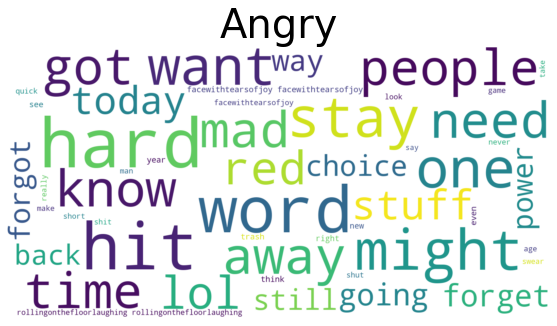

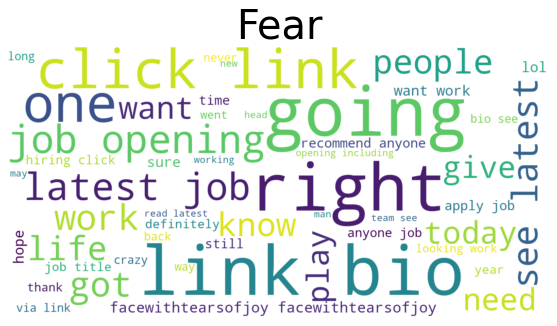

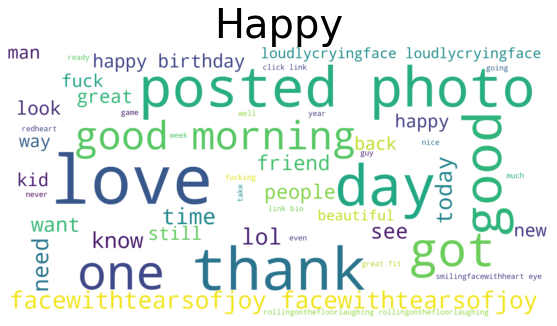

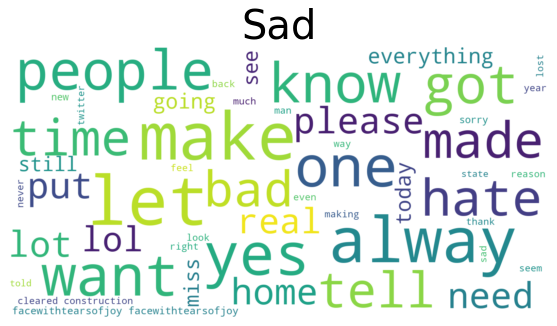

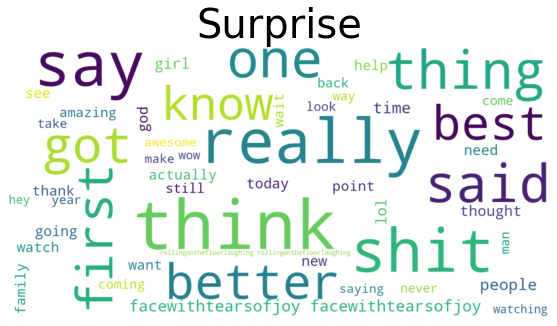

In [ ]:
### Converte lista strings em um único texto
labels = np.unique(df.Emotion_class)
for label in labels:
    rows = df[df.Emotion_class == label]
    corpus = " ".join(text for text in rows.clean_tweet)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate(corpus)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;  

### WordCloud Bigrams

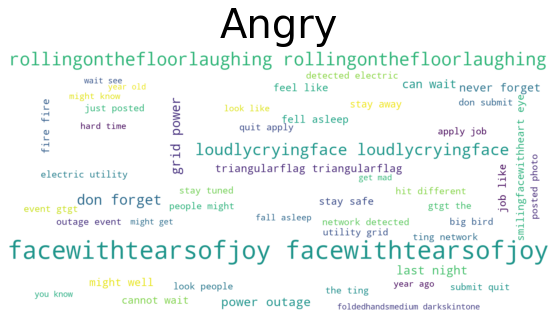

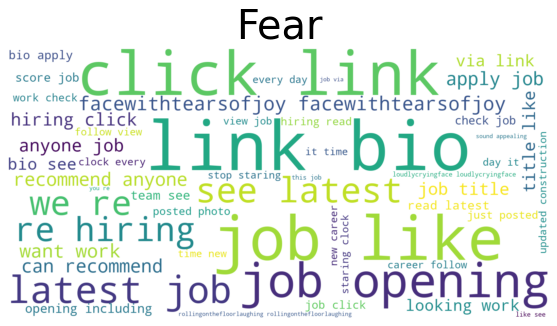

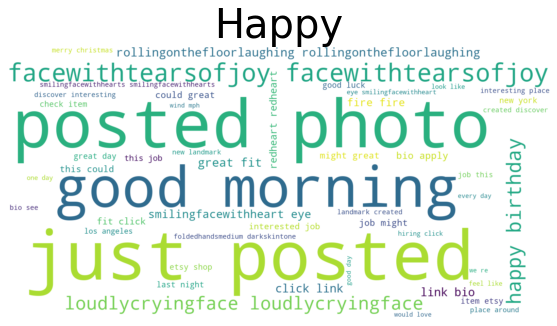

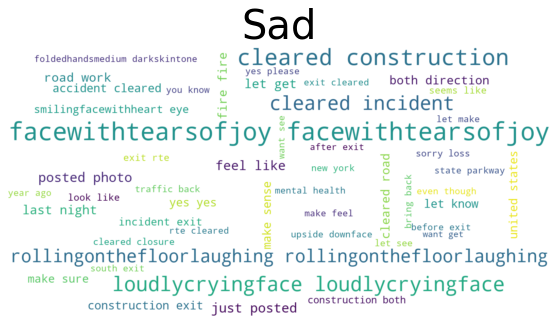

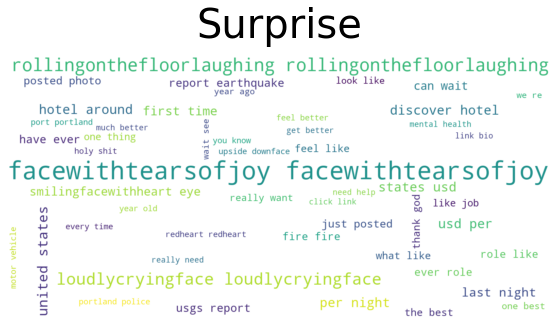

In [ ]:
exibe_wordcloud(2)

### WordCloud Trigrams

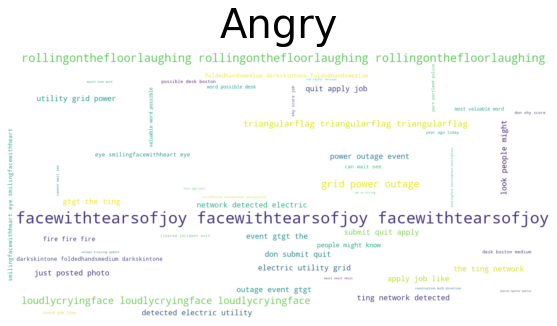

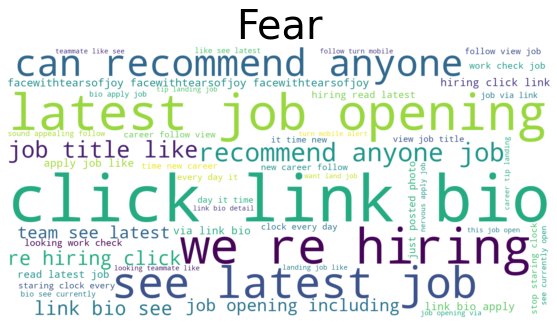

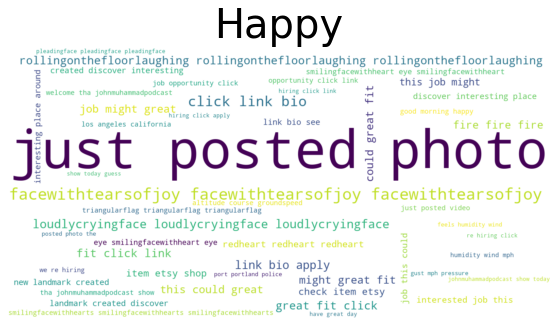

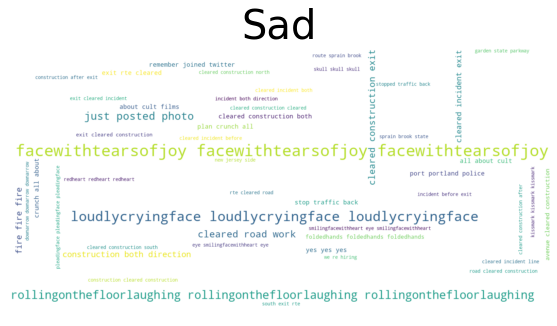

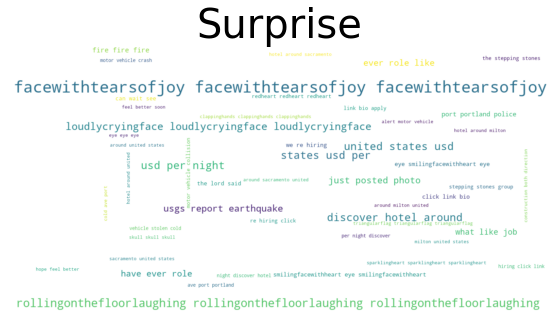

In [ ]:
exibe_wordcloud(3)

## Análise das Emoções - Classificação dos Tweets - Embedding e CNN-LSTM

### Encode Categorical Variable

In [ ]:
X = df.clean_tweet
y = pd.get_dummies(df['Emotion_class']).values

y

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

### Fixa uma semente para manter a reproução dos resultados

In [ ]:
seed = 101 
np.random.seed(seed)

#### Dividir a base em dados e labels (X,y)

In [ ]:
labels = np.unique(df.Emotion_class)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(168242,) (42061,) (168242, 5) (42061, 5)
(168242,) (42061,) (168242, 5) (42061, 5)


#### Tokeniza o texto

In [ ]:
from keras.preprocessing.text import Tokenizer
max_features = 30000 ### máximo de features utilizadas pelo tokenizador
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Calcula o total de palavras por tweet na base de treino

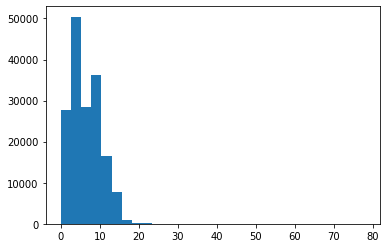

In [ ]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show();

In [ ]:
from keras.preprocessing import sequence
max_words = 30 ## Total de palavras pelo pré-processamento
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(168242, 30) (42061, 30)


## Análise de Emoções - Classificação dos Tweets - Embedding e CNN-LSTM

In [ ]:
import keras.backend as K
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

# Variáveis


In [ ]:
batch_size = 128
epochs = 40
init_lr = 1e-2
num_classes = df['Emotion_class'].nunique()
labels = np.unique(df.Emotion_class)

# Callbacks

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose = True,
                   monitor='val_loss', mode='min')
mc = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, verbose=True,
                     monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(patience = 2, verbose = True, 
                        factor=0.5, monitor='val_loss', restore_best_weights=True,
                        mode='min')

# Otimizador

In [ ]:
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #init_lr,
    #decay_steps=init_lr / epochs,
    #decay_rate=0.9)
opt = Adam(learning_rate=init_lr)

#### Função para montar a Rede Neural

In [ ]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features,
                        embed_dim,
                        input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32,
                     kernel_size=3,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32,
                     kernel_size=3,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(embed_dim, 
                   dropout=0.2,
                   return_sequences = True))
    
    model.add(LSTM(embed_dim, 
                   dropout=0.2,
                   return_sequences = True))
    
    model.add(LSTM(100, 
                   dropout=0.2, 
                   recurrent_dropout=0.2))
    model.add(Dense(num_classes, 
                    activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    return model

#### Função para treinar a Rede Neural

In [ ]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train,
                              y_train,
                              validation_data=(X_test, y_test), 
                          epochs=epochs,
                              batch_size=batch_size,
                              verbose=2,
                             callbacks=[es,rlr,mc])
    # plot train history
    plot_model_history(model_history)

#### Função verificação do Histórico de Treinamento

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show();

#### Função para avalição da Rede Neural

In [ ]:
def model_evaluate(): 
    # predict class with test set
    # y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0) código
    # deprecatede não utiliza mais model.predict_classes
    
    y_pred_test =  model.predict(X_test) # novo formato para fazer a prvisão das classes
    y_pred_test = np.argmax(y_pred_test, axis=1) # converte para array
    
  
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
   
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(10,10))
    ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = labels)\
                          .plot(cmap='Blues', xticks_rotation='vertical', ax=ax)

    #fig, ax = plt.subplots(figsize=(4, 4))
    #ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    #for i in range(confmat.shape[0]):
    #    for j in range(confmat.shape[1]):
    #        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

### Treinando o modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           3000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 7, 100)            5

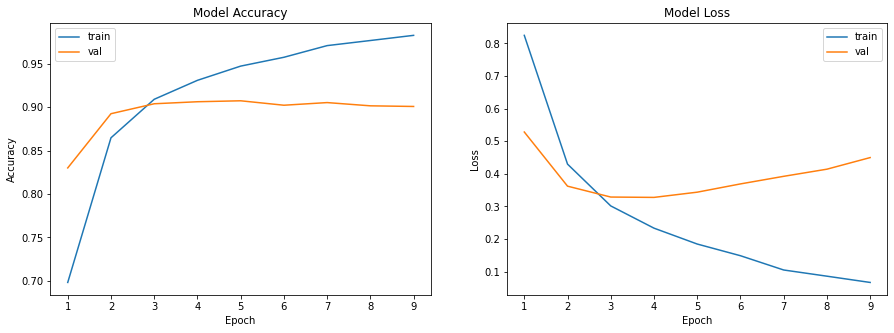

CPU times: user 11min 55s, sys: 1min 30s, total: 13min 25s
Wall time: 6min 30s


In [ ]:
%%time


max_features = 30000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	90.6%


              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1871
           1       0.86      0.88      0.87      7735
           2       0.95      0.94      0.94     18872
           3       0.86      0.86      0.86      5895
           4       0.90      0.91      0.90      7688

    accuracy                           0.91     42061
   macro avg       0.88      0.88      0.88     42061
weighted avg       0.91      0.91      0.91     42061

CPU times: user 7.04 s, sys: 432 ms, total: 7.47 s
Wall time: 5.91 s


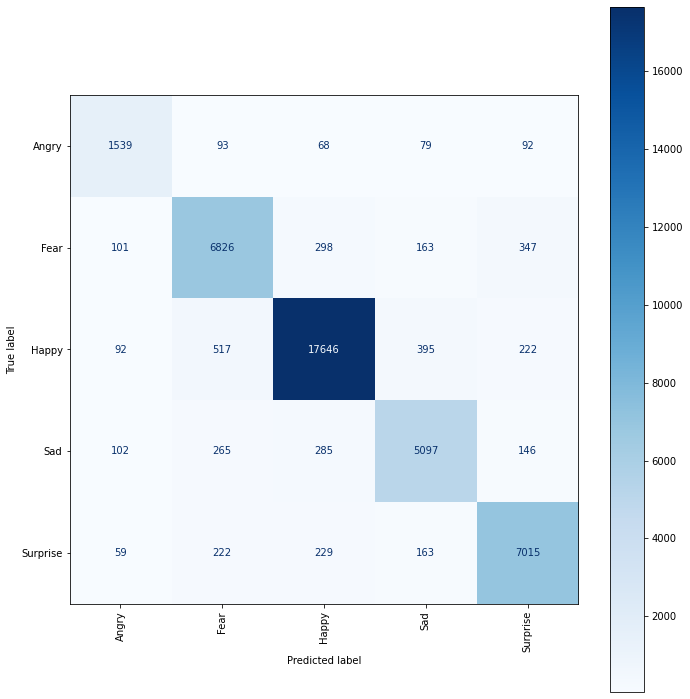

In [ ]:
%%time
# evaluate model with test set

model_evaluate()

Agora vamos botar um moldelo pretreinado mas ele vai treinar junto

 #### Função para montar a embedding_matrix twitter.27B.100d.txt + CNN-LSTM

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=30000):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

## Função para utilizar o embedding - Transfer Learning

In [ ]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix]))#,trainable=False
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))  
    model.add(LSTM(embed_dim, dropout=0.2, return_sequences = True))

    model.add(LSTM(embed_dim, dropout=0.2, return_sequences = True))

    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    return model

## Matriz de Embedding

In [ ]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt' ### 
embed_dim = 100 #word vector dim
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

Found 1193514 word vectors.


## Treinando o Modelo com embedding

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           3000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 7, 100)            5

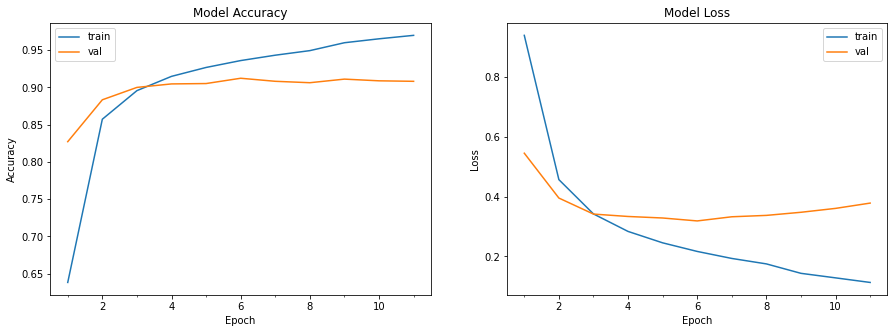

CPU times: user 14min 36s, sys: 1min 49s, total: 16min 26s
Wall time: 7min 10s


In [ ]:
%%time
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

## Avaliando o modelo com os Dados de teste

Accuracy:	91.2%


              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1871
           1       0.89      0.89      0.89      7735
           2       0.94      0.96      0.95     18872
           3       0.87      0.86      0.87      5895
           4       0.90      0.90      0.90      7688

    accuracy                           0.91     42061
   macro avg       0.89      0.88      0.88     42061
weighted avg       0.91      0.91      0.91     42061

CPU times: user 7.04 s, sys: 419 ms, total: 7.46 s
Wall time: 5.9 s


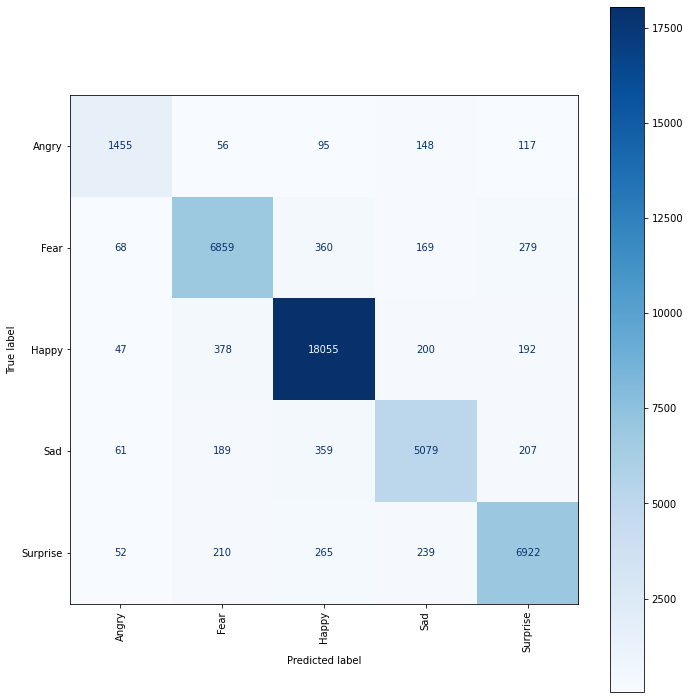

In [ ]:
%%time


model_evaluate()

Agora congelanddo o modelo glove

In [ ]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix],trainable=False)) ### cogela a camada de embeding
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(embed_dim, dropout=0.2, return_sequences = True))

    model.add(LSTM(embed_dim, dropout=0.2, return_sequences = True))


    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))


    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    return model

## Treinando o Modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           3000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 7, 100)            5

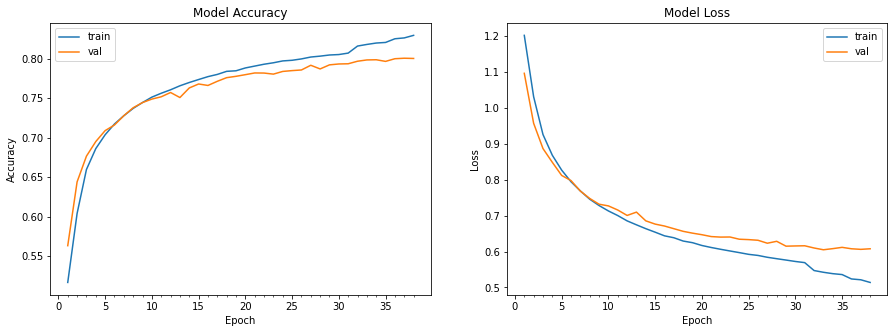

CPU times: user 49min 5s, sys: 6min 13s, total: 55min 19s
Wall time: 23min 46s


In [ ]:
%%time
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

Accuracy:	79.8%


              precision    recall  f1-score   support

           0       0.72      0.54      0.62      1871
           1       0.76      0.67      0.71      7735
           2       0.83      0.92      0.87     18872
           3       0.75      0.66      0.70      5895
           4       0.81      0.80      0.80      7688

    accuracy                           0.80     42061
   macro avg       0.77      0.72      0.74     42061
weighted avg       0.79      0.80      0.79     42061

CPU times: user 7.03 s, sys: 412 ms, total: 7.45 s
Wall time: 5.9 s


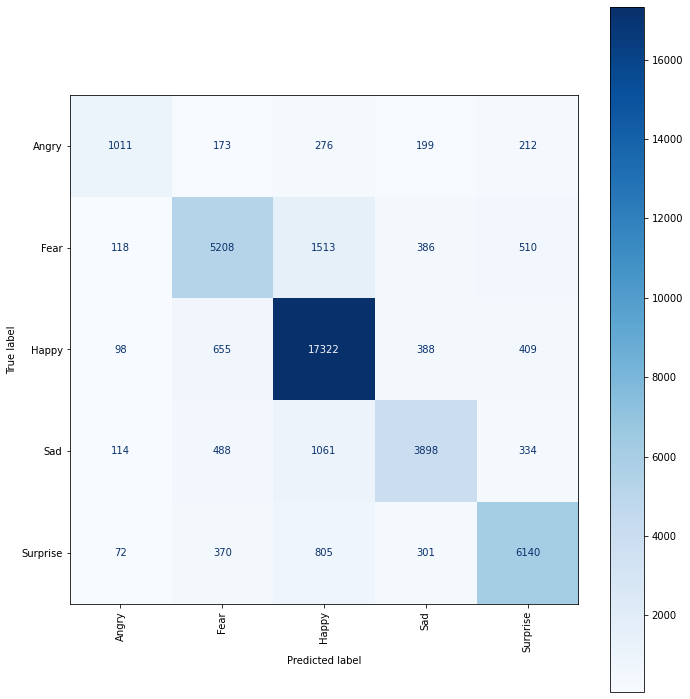

In [ ]:
%%time
# evaluate model with test set

model_evaluate()